<a href="https://colab.research.google.com/github/PhilipPfeffer/haptic_vest/blob/main/resnet34_oracle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resnet34 Oracle with X examples
Note that because the 'car' dataset only has 2460 examples, there are not as many images as the num_examples_name.

This block can be run with no changes.

In [1]:
import fastai
from fastai import *
from fastai.vision import *
import os
import zipfile
# print(fastai.__version__ )

# Get dataset_X from zip


In [6]:
dataset_name = 'dataset_three'
zip_file_path = '/content/' + dataset_name + '.zip'
unzipped_dir = '/content'
dataset_X = '/content/' + dataset_name
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzipped_dir)

# You need to change lines here to get the specific dataset.
Download the .zip of your images into Colab's directory, not
into My Drive (your mounted Google Drive).

In [7]:

# # !apt install unzip
# # !mkdir dataset_X

# ######################### 
# # CHANGE HERE
# ######################### 
# num_examples_name = '5000'
# ######################### 

# dataset_X_parent = '/content/dataset_' + num_examples_name
# dataset_X = '/content/dataset_' + num_examples_name + '/processed_subset' + num_examples_name
# # os.mkdir(dataset_X_parent)  # Uncomment if directory doesn't exist
# !unzip '/content/processed_subset5000-20201022T193533Z-001.zip' -d dataset_5000

In [8]:
# dataset_X_ids = {}
# for entry in os.scandir(dataset_X):
#   if os.path.basename(entry)[0] == '.':
#     continue
#   dataset_X_ids[int(os.path.basename(entry)[:-4])] = train_ids_dict[int(os.path.basename(entry)[:-4])]
# len(dataset_X_ids)

In [9]:
# dataset_X_fnames = get_image_files(dataset_X)
# dataset_X_labels = [train_ids_dict[int(fname.parts[-1][:-4])] for fname in dataset_X_fnames]
# print(len(dataset_X_labels))

# FastAI

## Make databunch_X
Here we have a 90/10 train/dev split

In [10]:
# databunch_X = ImageDataBunch.from_lists(dataset_X, dataset_X_fnames, dataset_X_labels, valid_pct=0.1).normalize(imagenet_stats)
# print(databunch_X)

In [19]:
path = '/content/dataset_three'
databunch_X = ImageDataBunch.from_folder(path, train='train', valid='dev', test='test', size=96).normalize(imagenet_stats)

(['0', '1', '3'], 3, 65955, 9225)

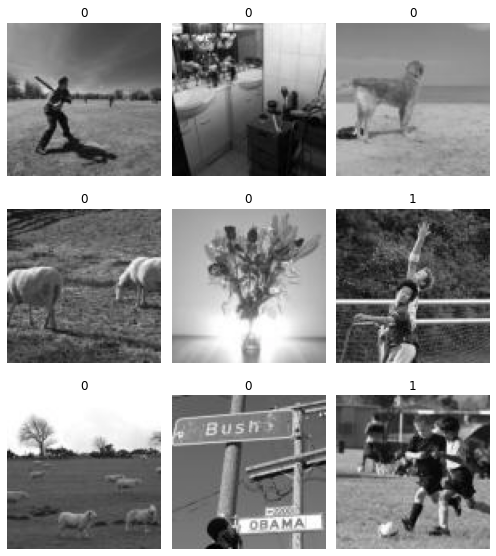

In [20]:
np.random.seed(42)

databunch_X.show_batch(rows=3, figsize=(7,8))
databunch_X.classes, databunch_X.c, len(databunch_X.train_ds), len(databunch_X.valid_ds)

## Stage 1

In [21]:
learner_X = cnn_learner(databunch_X, models.resnet34, metrics=[error_rate, accuracy])

In [22]:
learner_X.fit_one_cycle(40)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.566051,0.413888,0.169106,0.830894,01:06
1,0.439463,0.357612,0.153388,0.846612,01:06
2,0.361833,0.322746,0.137453,0.862547,01:06
3,0.335586,0.299947,0.124661,0.875339,01:06
4,0.315527,0.277451,0.114363,0.885637,01:06
5,0.305925,0.271622,0.108943,0.891057,01:07
6,0.277323,0.267700,0.105366,0.894634,01:06
7,0.267999,0.256129,0.102114,0.897886,01:07
8,0.282504,0.251815,0.099404,0.900596,01:06
9,0.250504,0.256029,0.094201,0.905799,01:06


In [23]:
learner_X.save('learner_' + dataset_name + '_stage-1')


In [24]:
interp = ClassificationInterpretation.from_learner(learner_X)

losses,idxs = interp.top_losses()

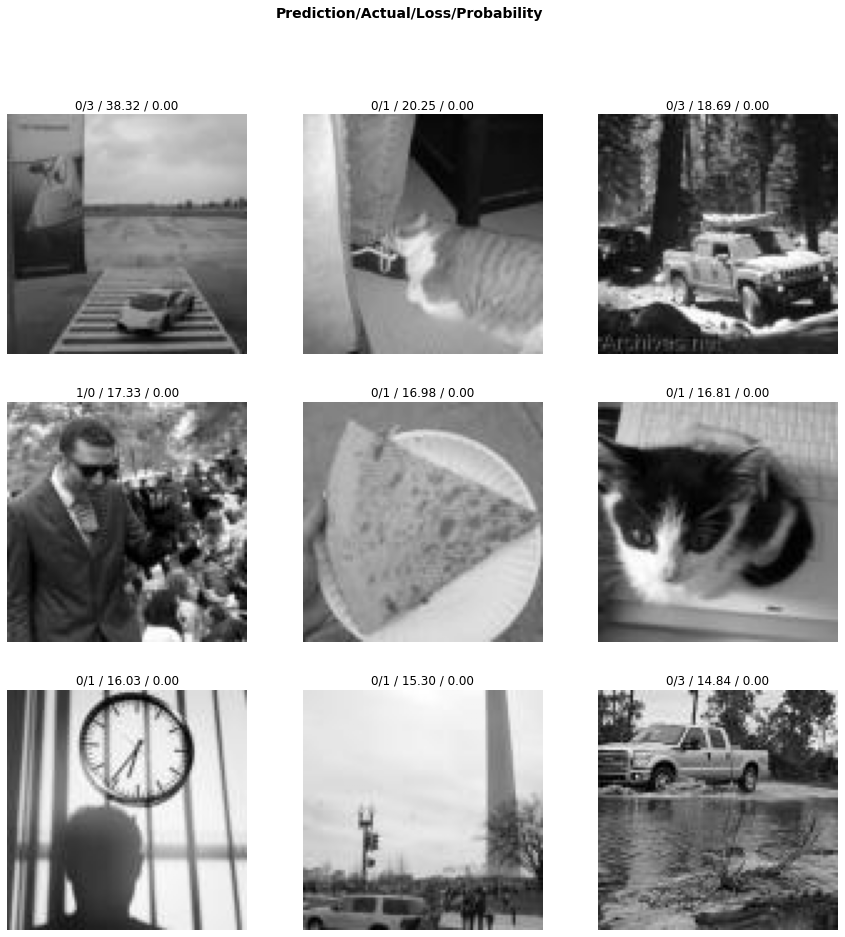

In [25]:
interp.plot_top_losses(9, figsize=(15,15), heatmap=True)


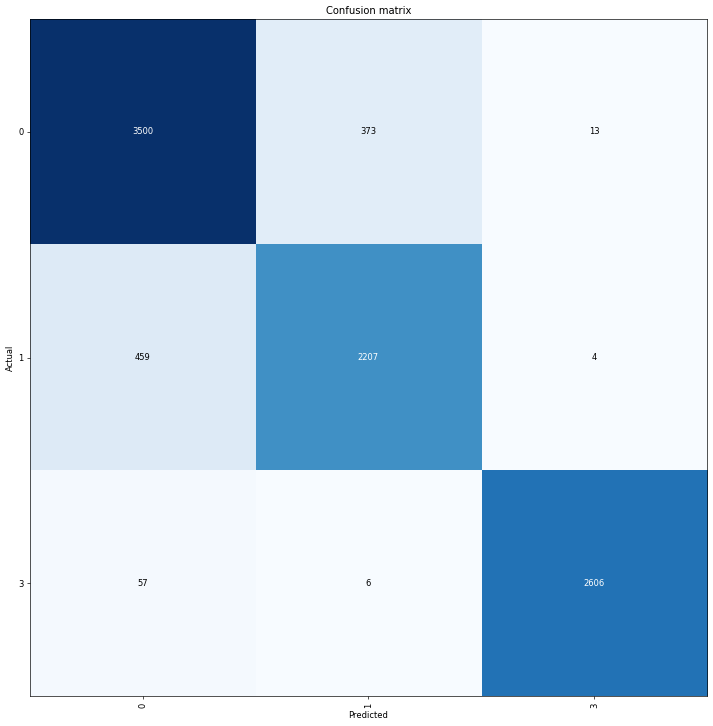

In [26]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


## Stage 2

In [27]:
learner_X.load('learner_' + dataset_name + '_stage-1');

In [28]:
learner_X.unfreeze()

In [29]:
learner_X.lr_find()


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


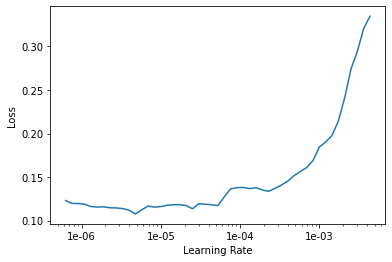

In [30]:
learner_X.recorder.plot()


In [31]:
learner_X.fit_one_cycle(20, max_lr=slice(3e-6,3e-5))


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.122896,0.320738,0.097778,0.902222,01:33
1,0.126679,0.322736,0.098103,0.901897,01:32
2,0.111003,0.322935,0.099187,0.900813,01:32
3,0.100640,0.333255,0.098537,0.901463,01:33
4,0.093598,0.357920,0.098753,0.901247,01:32
5,0.081109,0.375705,0.102981,0.897019,01:32
6,0.050382,0.414660,0.099946,0.900054,01:32
7,0.040919,0.448763,0.096477,0.903523,01:33
8,0.036562,0.472740,0.100705,0.899295,01:33
9,0.022669,0.474595,0.096694,0.903306,01:33


In [ ]:
learner_X.lr_find()


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


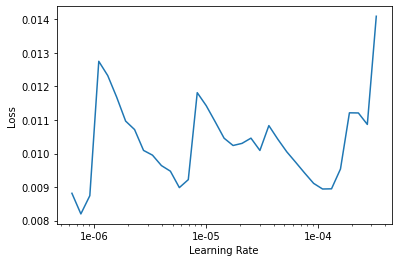

In [ ]:
learner_X.recorder.plot()


In [ ]:
learner_X.save('learner_' + dataset_name + '_stage-2')


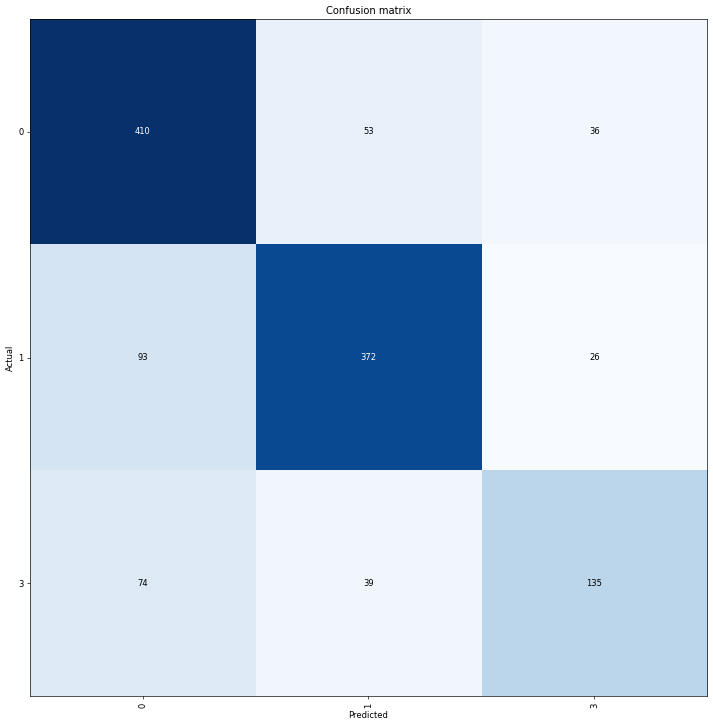

In [ ]:
interp = ClassificationInterpretation.from_learner(learner_X)

losses,idxs = interp.top_losses()
# interp.plot_top_losses(9, figsize=(15,15), heatmap=True)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Cleanup dataset_X
It turns out that MSCOCO is not that great a dataset, so here's a widget that helps you clean the dataset.

In [ ]:
from fastai.widgets import *

In [ ]:
databunch_X_clean = ImageDataBunch.from_lists(dataset_X, dataset_X_fnames, dataset_X_labels)


In [ ]:
learn_clean_X = cnn_learner(databunch_X_clean, models.resnet34, metrics=error_rate)

learn_clean_X.load('learner_' + dataset_name + '_stage-2');

In [ ]:
ds_formatter_X, idxs_formatter_X = DatasetFormatter().from_toplosses(learn_clean_X)

In [ ]:
ImageCleaner(ds_formatter_X, idxs_formatter_X, dataset_X)


Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

([0, 1, 3], 3, 8912, 990)

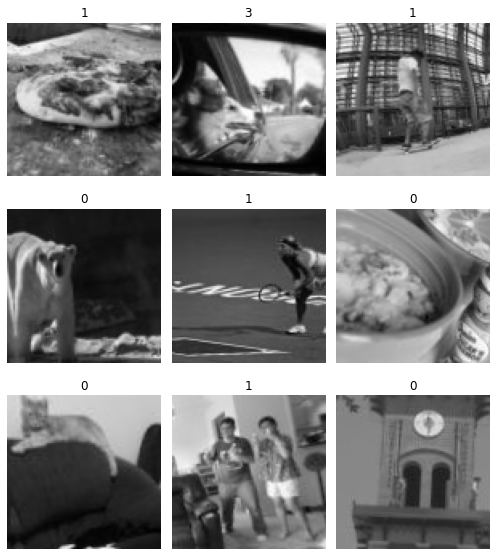

In [ ]:
np.random.seed(42)
dataset_X_clean = ImageDataBunch.from_csv(dataset_X, folder=".", valid_pct=0.1, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=96, num_workers=4).normalize(imagenet_stats)

dataset_X_clean.classes

dataset_X_clean.show_batch(rows=3, figsize=(7,8))
dataset_X_clean.classes, dataset_X_clean.c, len(dataset_X_clean.train_ds), len(dataset_X_clean.valid_ds)

In [ ]:
learn_clean_X = cnn_learner(dataset_X_clean, models.resnet34, metrics=[error_rate, accuracy])

In [ ]:
learn_clean_X.fit_one_cycle(20, max_lr=3e-3)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.344006,0.838741,0.317172,0.682828,00:19
1,1.100868,0.742262,0.279798,0.720202,00:19
2,0.888042,0.685791,0.268687,0.731313,00:19
3,0.732537,0.647699,0.245455,0.754545,00:19
4,0.667994,0.622950,0.245455,0.754545,00:19
5,0.677468,0.594366,0.251515,0.748485,00:19
6,0.635505,0.597963,0.243434,0.756566,00:19
7,0.626675,0.599717,0.242424,0.757576,00:19
8,0.601547,0.579456,0.228283,0.771717,00:19
9,0.587298,0.571505,0.233333,0.766667,00:19
